In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from collections import Counter
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.style as mplstyle
import matplotlib.patches as mpatches
from matplotlib.ticker import (PercentFormatter,MultipleLocator, AutoMinorLocator)
import seaborn as sns
import random

In [2]:
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

In [3]:
pd.set_option('display.max_rows', 500)

In [4]:
conn = psycopg2.connect(database="postgres",
                        host="pklmart.ckkvdwandqoa.us-east-1.rds.amazonaws.com",
                        user="cmcnicholas",
                        password="momentum101",
                        port="5432")
conn.autocommit = True

In [5]:
def pullawsdata(tablename):
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(f"SELECT column_name FROM information_schema.columns where table_name=\'{tablename}\';")
            cols=cursor.fetchall()
            cols = [cols[x][0] for x in range(len(cols))]
            cursor.execute(f"SELECT * FROM pklm_prd.{tablename}")
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=cols))
        except Exception as inst:
            print(type(inst))
            print(inst.args)
            print(inst)

In [6]:
def generate_streak_info(df,strkcol):
    """
    Parameters
    ----------
    df: A chronologically pre-sorted homogenous dataframe,\
    strkcol: Column within df with 2 unique values    
    Returns
    -------
    streaks: df with a new column strk_{strkcol} with running streak sum
    """
    data = df[strkcol].to_frame()
    data['strk_init'] = data[strkcol].ne(data[strkcol].shift())
    data['strk_id'] = data.strk_init.cumsum()
    strk_field = f'strk_{strkcol}'
    data[strk_field] = data.groupby('strk_id').cumcount() + 1
    streaks = pd.concat([df, data[strk_field]], axis=1)
    streaks[strk_field] = streaks[strk_field].astype(int)
    return streaks

In [7]:
def streakdist(l):
    """
    Parameters
    -----------
    l:nested list of nested lists of streak lists
    Returns
    -------
    dist:list of tuples (x,y) where x is streak length and y is frequency
    """
    return list(Counter(sorted(sum([x[1]*[x[0]] for x in sum(l,[])],[]))).items())

In [8]:
def streakpct(d):
    """
    Parameters
    -----------
    d:list of tuples (x,y) where x is streak length and y is frequency
    Returns
    -------
    pcts:list of tuples (x,y) where x is streak length and y is percentage
    """    
    num = sum([x[1] for x in d])
    pcts = [(x[0],round(100*(x[1]/num),2)) for x in d]
    return pcts

In [9]:
def streakcounter(skill='All'):
    #pull game data
    game=pullawsdata('game')[['match_id','game_id','game_nbr','score_w','score_l','w_team_id','l_team_id','skill_lvl']]
    game['game_id'] = [int(x[1:]) for x in game.game_id]
    game['match_id'] = [int(x[1:]) for x in game.match_id]
    game.skill_lvl.iloc[game.skill_lvl == '5'] = '5.0'
    game = game.sort_values(['match_id','game_id']).reset_index(drop=True)
    
    #pull rally data
    rally=pullawsdata('rally')
    rally = rally[['game_id', 'rally_id', 'rally_nbr', 'srv_team_id', 'w_team_id', 'to_team_id']]
    rally['game_id'] = [int(x[1:]) for x in rally.game_id]
    rally['rally_id'] = [int(x[1:]) for x in rally.rally_id]
    rally = rally.sort_values(['game_id', 'rally_id', 'rally_nbr']).reset_index(drop=True)
    
    #create column 'srv_win' capturing the rally winner if serving
    sloc = rally.index[rally.srv_team_id == rally.w_team_id]
    rally['srv_win'] = rally.srv_team_id.iloc[sloc]

    #filter to skill level
    print(f'Counting streak lengths pre/post timeout for skill level: {str.upper(skill)}\n')
    if skill[0] in ['4','5']:
        skill_games = game.game_id[game.skill_lvl == str(float(skill))]
        rally = rally[list(pd.DataFrame(rally['game_id']).stack().isin(skill_games).groupby(level=0).any())]
    elif skill == 'Pro':
        skill_games = game.game_id[game.skill_lvl == 'Pro']
        rally = rally[list(pd.DataFrame(rally['game_id']).stack().isin(skill_games).groupby(level=0).any())]
    elif skill == 'Amateur':
        skill_games = game.game_id[game.skill_lvl != 'Pro']
        rally = rally[list(pd.DataFrame(rally['game_id']).stack().isin(skill_games).groupby(level=0).any())]
    
    #remove games without timeouts
    to_games=[]
    for i in game.game_id:
        igame = rally[rally.game_id==i]
        if len(igame[igame.to_team_id != 'N/A']) > 0:
            to_games.append(i)
    rally = rally[list(pd.DataFrame(rally['game_id']).stack().isin(to_games).groupby(level=0).any())]

    #generate streaks of timeout taking team's opponent winning as server
    srv_win_strks=[]
    for i in game.game_id:
        dfi = rally[rally.game_id==i]
        dfi = generate_streak_info(dfi,'srv_win')
        srv_win_strks.append(list(dfi.strk_srv_win))
    srv_win_strks = list(np.concatenate(srv_win_strks).flat)
    srv_win_strks = [int(x) for x in srv_win_strks]
    rally['srv_win_strks'] = srv_win_strks
    rally.srv_win_strks.iloc[rally.srv_win.isnull()] = 0
    #must set srv_win to srv_team_id after streak lengths are generated, allowing filtering to streak 0s (server loses)
    rally.srv_win = rally.srv_team_id
    
    #count opponent serve win streak length freqencies pre and post timeout
    glist = list(rally.game_id.unique())
    lencnt_pre_list = []
    lencnt_post_list = []
    for i in glist:
        gi = rally[rally.game_id==i].reset_index(drop=True)
        to_list = []
        #print(f'game: {i}')
        to_inds = list(gi.index[gi.to_team_id != 'N/A'])
        to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
        skill_lvl = list(game.skill_lvl[game.game_id == i])[0]
        if (len(to_inds) > 0):
            for j in range(len(to_inds)):
                #print(f'timeout #{j+1}')
                if j == 0:
                    pre = list(range(to_inds[j]))
                else:
                    pre = list(range(to_inds[j-1]+1,to_inds[j]))
                if j == len(to_inds)-1:
                    post = list(range(to_inds[j]+1,len(gi)))
                else:
                    post = list(range(to_inds[j]+1,to_inds[j+1]))
                toteam = to_teams[j]
                rallynbr = gi.rally_nbr.iloc[to_inds[j]]

                streak_pre = sorted(list(gi.loc[pre][gi.apply(lambda x:(x.srv_win != toteam) and (pd.notnull(x['srv_win'])),axis=1)]['srv_win_strks']))
                if len(streak_pre) > 0:
                    #print(f'streaks pre: {streak_pre}')
                    cntlist_pre = list(Counter(streak_pre).values())
                    #print(f'overcounted lengths pre: {cntlist_pre}')
                    klist_pre = list(Counter(streak_pre))
                    #print(f'lengths only pre: {klist_pre}')
                    allcnt_pre = [[klist_pre[x],cntlist_pre[x]-cntlist_pre[x+1]] for x in range(len(cntlist_pre)-1)]
                    #print(f'start of length counts pre = {allcnt_pre}')
                    allcnt_pre.insert(len(allcnt_pre),[klist_pre[-1],cntlist_pre[-1]])
                    #print(f'remaining counts pre: {allcnt_pre}')
                else:
                    allcnt_pre=[(0,0)]
                #print(f'final streak length counts pre: {allcnt_pre}\n\n')
                lencnt_pre_list.append(allcnt_pre)

                streak_post = sorted(list(gi.loc[post][gi.apply(lambda x:(x.srv_win != toteam) and (pd.notnull(x['srv_win'])),axis=1)]['srv_win_strks']))
                if len(streak_post) > 0:
                    #print(f'streaks post: {streak_post}')
                    cntlist_post = list(Counter(streak_post).values())
                    #print(f'overcounted lengths post: {cntlist_post}')
                    klist_post = list(Counter(streak_post))
                    #print(f'lengths only post: {klist_post}')
                    allcnt_post = [[klist_post[x],cntlist_post[x]-cntlist_post[x+1]] for x in range(len(cntlist_post)-1)]
                    #print(f'start of length counts post = {allcnt_post}')
                    allcnt_post.insert(len(allcnt_post),[klist_post[-1],cntlist_post[-1]])
                    #print(f'remaining counts post: {allcnt_post}')
                else:
                    allcnt_post=[(0,0)]
                #print(f'final streak length counts post: {allcnt_post}\n\n')
                lencnt_post_list.append(allcnt_post)
    
    #tuples of streak length frequencies
    dist_pre = streakdist(lencnt_pre_list)
    dist_post = streakdist(lencnt_post_list)
    
    df_counts_pre = pd.DataFrame(dist_pre,columns=['streak','counts_pre'])
    df_counts_post = pd.DataFrame(dist_post,columns=['streak','counts_post'])
    df_counts_prepost = pd.concat([df_counts_pre,df_counts_post[['counts_post']]],axis=1)
    df_counts_prepost['counts_total']=df_counts_prepost.counts_pre+df_counts_prepost.counts_post
    df_counts_prepost = df_counts_prepost.fillna(0).astype(int)
    print(f'frequencies of streak lengths ({str.upper(skill)}):\n\n {df_counts_prepost.to_string(index=False)}')
    
    #tuples of streak length frequencies percentages
    pcts_pre = streakpct(dist_pre)
    pcts_post = streakpct(dist_post)
    
    df_pcts_pre = pd.DataFrame(pcts_pre,columns=['streak','pct_pre'])
    df_pcts_post = pd.DataFrame(pcts_post,columns=['streak','pct_post'])
    df_pcts_prepost = pd.concat([df_pcts_pre,df_pcts_post[['pct_post']]],axis=1)
    totcount = sum(df_counts_prepost.counts_total)
    pcts_total = [round(100*x/totcount,2) for x in df_counts_prepost.counts_total]
    df_pcts_prepost['pct_all']=pcts_total
    df_pcts_prepost = df_pcts_prepost.fillna(0.0).astype(float)

    print(f'\npercentages of streak lengths ({str.upper(skill)}):\n\n {df_pcts_prepost.to_string(index=False)}\n\n')
    
    return([df_counts_prepost,df_pcts_prepost])

In [10]:
df_counts_all,df_pcts_all = streakcounter()
df_counts_pro,df_pcts_pro = streakcounter('Pro')
#df_counts_amt,df_pcts_amt = streakcounter('Amateur')
#df_counts_4,df_pcts_4 = streakcounter('4')
#df_counts_45,df_pcts_45 = streakcounter('4.5')
#df_counts_5,df_pcts_5 = streakcounter('5')

Counting streak lengths pre/post timeout for skill level: ALL

frequencies of streak lengths (ALL):

  streak  counts_pre  counts_post  counts_total
      0         226          130           356
      1         179          102           281
      2          54           25            79
      3          22            9            31
      4           8            2            10
      5           3            1             4

percentages of streak lengths (ALL):

  streak  pct_pre  pct_post  pct_all
    0.0    45.93     48.33    46.78
    1.0    36.38     37.92    36.93
    2.0    10.98      9.29    10.38
    3.0     4.47      3.35     4.07
    4.0     1.63      0.74     1.31
    5.0     0.61      0.37     0.53


Counting streak lengths pre/post timeout for skill level: PRO

frequencies of streak lengths (PRO):

  streak  counts_pre  counts_post  counts_total
      0         153          110           263
      1         138           79           217
      2          39           22

In [11]:
def plotextra(dfs):
    streak = dfs.streak
    pct_pre = dfs.pct_pre
    pct_post = dfs.pct_post
    pct_all = dfs.pct_all
    
    l=[100]
    for x in range(6):l.append(l[-1]/2)
    df_coin = pd.DataFrame(l[1:],columns=['coin']).round(2)
    dfs = pd.concat([dfs,df_coin],axis=1)
    pct_coin = dfs.coin
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    width = 0.4

    plt.plot(streak,pct_coin,marker=".",color="gainsboro",label='infinite coinflips')
    plt.plot(streak,pct_all,marker=".",color="gainsboro",linestyle = "dashed",label='before & after')

    plt.bar(streak-(width/2)-(width/32),pct_pre,width,color="skyblue",label="before timeout")
    plt.bar(streak+(width/2)+(width/32),pct_post,width,color="deepskyblue",label="after timeout")

    plt.legend(loc="upper right",facecolor='black', framealpha=1,labelcolor = "linecolor")
    ax.set_ylim(0,60)
    ax.set_title("Timeout Impact On Opponent Momentum")
    ax.set_xlabel("Opponent Winning As Server Streak Length")
    ax.set_ylabel("Percentage")
    ax.set_facecolor('dimgrey')

    plt.show()

All Skills:



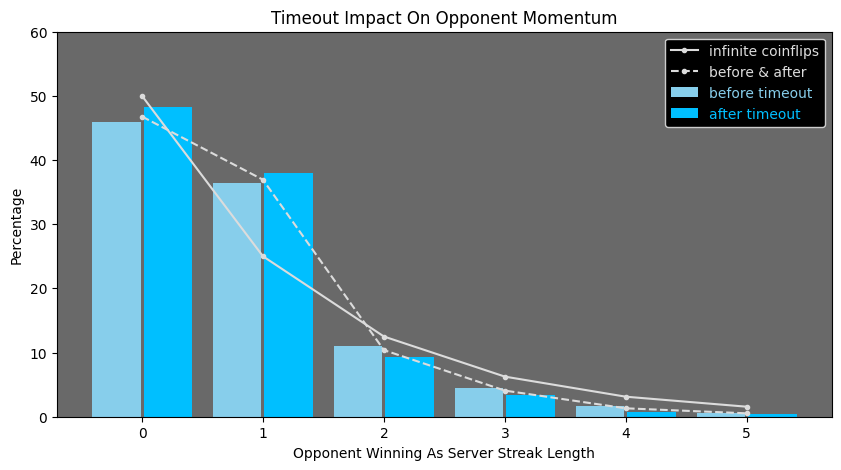

Pro:



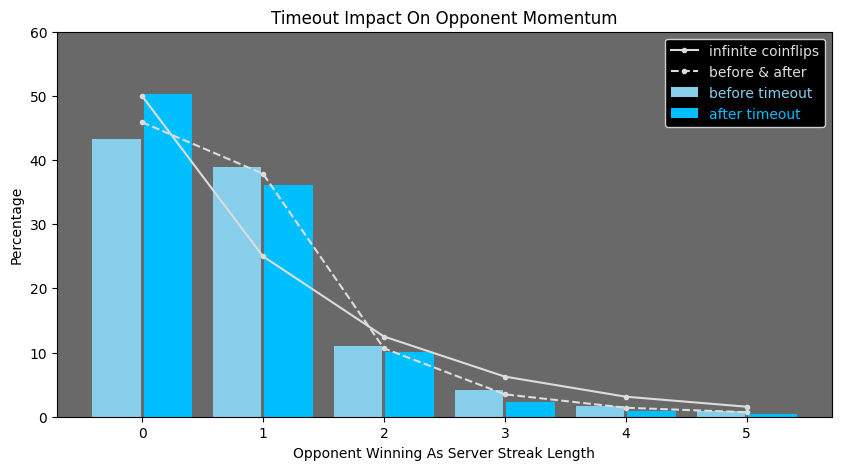

In [12]:
print('All Skills:\n')
plotextra(df_pcts_all)
print('Pro:\n')
plotextra(df_pcts_pro)